In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../datasets/train_fake_news.csv")

In [3]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


Drop NaN Values

In [4]:
df = df.dropna()

Get Independent Features

In [5]:
X = df.drop('label' , axis = 1)

Get Dependent Features

In [6]:
y = df['label']

In [7]:
X.shape

(18285, 4)

In [9]:
import tensorflow as tf

In [10]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [11]:
voc_size = 5000

#### One Hot Representation

In [12]:
messages = X.copy()

In [13]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

As some rows were dropped due to NaN values reset the index of each row

In [15]:
messages.reset_index(inplace = True)

In [16]:
import nltk
import re
from nltk.corpus import stopwords

##### Dataset Preprocessing

In [18]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [20]:
corpus[10]

'russian research discov secret nazi militari base treasur hunter arctic photo'

In [21]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [22]:
onehot_repr[10]

[2086, 1201, 333, 1226, 3693, 453, 1376, 4892, 491, 4273, 3946]

#### Embedding Representation

Pad to make sentence length same

In [23]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2294 4088 3300]
 [   0    0    0 ... 2725  262  970]
 [   0    0    0 ...  726 1866 1828]
 ...
 [   0    0    0 ... 3846 1039 2207]
 [   0    0    0 ... 2528 4965 2043]
 [   0    0    0 ...  958 1626 3411]]


In [24]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 4322,
       2335, 1277, 3358, 3602, 1785, 1016, 2294, 4088, 3300])

##### Create Model

In [32]:
from tensorflow.keras.layers import Dropout

embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))

# Sigmoid as binary classification problem i.e fake news or not
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
len(embedded_docs),y.shape

(18285, (18285,))

In [34]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

#### Split into train , test and train the model

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [36]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
192/192 [==============================] - 8s 32ms/step - loss: 0.3502 - accuracy: 0.8322 - val_loss: 0.1951 - val_accuracy: 0.9163
Epoch 2/10
192/192 [==============================] - 7s 35ms/step - loss: 0.1511 - accuracy: 0.9412 - val_loss: 0.2075 - val_accuracy: 0.9150
Epoch 3/10
192/192 [==============================] - 6s 33ms/step - loss: 0.1102 - accuracy: 0.9592 - val_loss: 0.1964 - val_accuracy: 0.9233
Epoch 4/10
192/192 [==============================] - 6s 31ms/step - loss: 0.0810 - accuracy: 0.9717 - val_loss: 0.2137 - val_accuracy: 0.9173
Epoch 5/10
192/192 [==============================] - 6s 31ms/step - loss: 0.0575 - accuracy: 0.9798 - val_loss: 0.2698 - val_accuracy: 0.9191
Epoch 6/10
192/192 [==============================] - 6s 32ms/step - loss: 0.0397 - accuracy: 0.9855 - val_loss: 0.3126 - val_accuracy: 0.9160
Epoch 7/10
192/192 [==============================] - 7s 36ms/step - loss: 0.0271 - accuracy: 0.9911 - val_loss: 0.3432 - val_accuracy: 0.9176

#### Performance metrics and accuracy

In [39]:
y_pred=(model.predict(X_test) > 0.5).astype("int32")

189/189 [==============================] - 2s 6ms/step


In [40]:
from sklearn.metrics import confusion_matrix

In [43]:
import matplotlib.pyplot as plt
import itertools

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [45]:
cm = confusion_matrix(y_test,y_pred)

Confusion matrix, without normalization


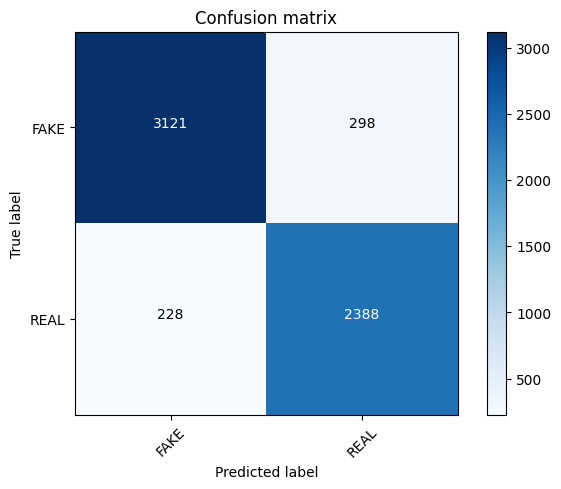

In [47]:
plot_confusion_matrix(cm , classes=['FAKE', 'REAL'])

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9128417564208782